In [1]:
import numpy as np
from scipy.interpolate import griddata
from scipy.interpolate import interp2d
import matplotlib.pyplot as plt
%matplotlib inline


Bad key "text.kerning_factor" on line 4 in
D:\anaconda\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
# set parameters based on Student Id 2022213266
S0 = 1.5 # Initial price
K = 1.4 # Strick price
U = 1.71 # Upper Bound
L = 1.29 # Upper Bound
I_U = 1.8 # interval_upper bound, 
I_L = 1.3 # interval_lower bound
time_to_maturity = 1  # 到期时间
interest_rate = 0.03  # 无风险利率

In [3]:
# 生成历史数据
M = 100
N = 100
option_value_history = [] # 用来存放历史数据
for i in range(N+1): # 时间分割 101
    for j in range(M): # strick price的分割 100
        K_temp = K/M* 2 * (j+1) # 每次循环中的strick price  0.028,0.056,...,2.8
        time_to_maturity_temp = time_to_maturity/N*i # 每次循环中的成熟期： 0,0.01,0.02，....，1
        dt = time_to_maturity_temp/100 # 将每个小时间区间进一步分割成100份，是为了求该循环下的C（K_temp，time_to_maturity_temp）
        volatility = 0.2  # 初始波动率 based on 学号2022213266，里面2最多，故2/10=0.2
        # 下面求每个循环下的股价矩阵
        log_returns = (interest_rate - 0.5 * volatility**2) * dt + volatility * np.sqrt(dt) * np.random.standard_normal(size=(100, 100)) # e的幂
        log_returns = np.vstack((np.zeros(100), log_returns))
        price_path = S0 * np.exp(np.cumsum(log_returns, axis=0))
        price_path = price_path.T # 每个小循环中的股价矩阵，其中行为蒙特卡罗次数，列为时间分割
        paths_local = price_path.copy() # 先保存一份,下面的操作在paths_local上进行
        payoff_local = np.zeros((100,101))
        # 下面求每个循环下的股价矩阵的生存情况（barrier option）
        for i in range(100): # 模拟次数100次
            for j in range(0,101): # 时间点0-100，一共101
                # 此处，我们讨论第一种情况，如果全期有上边界U=1.71，只要我股价不reach1.71，那就算survive，否则后面都看做0
                # 此时时刻为 j*time_to_maturity_temp/N*i/100
                t_temp = j*time_to_maturity_temp/N*i/100
                if (paths_local[i,j] < U and t_temp<=0.5) or (t_temp>0.5 and j<=(8/12)) or (paths_local[i,j] > L and (t_temp>=(8/12)) and t_temp<=(11/12)) or (paths_local[i,j]>=1.3 and paths_local[i,j]<=1.8 and t_temp>=int(11/12)):
                    payoff_local[i,j] = np.maximum(0,paths_local[i,j]-K_temp) # 存活的情况下，计算payoff
                else:   # 但凡碰到了barrier
                    paths_local[i,j:] = 0 # 股价生存情况 
                    payoff_local[i,j] = 0  # payoff情况
                    break
        option_value_temp = (payoff_local[:,-1].mean())*np.exp(-1*interest_rate*time_to_maturity_temp)
        option_value_history.append(option_value_temp)

In [4]:
# option_value_history 是一个 一维数组，下面reshape成矩阵形式
option_value_history = np.array(option_value_history)
option_value_history = option_value_history.reshape(N+1,M)
option_value_history = option_value_history.T # M*(N+1)的矩阵

In [5]:
option_value_history

array([[1.472     , 1.47484889, 1.47853994, ..., 0.64472783, 0.68493716,
        0.79345856],
       [0.69486981, 0.62394405, 0.64999231, ..., 0.71058566, 0.69217453,
        0.58736471],
       [0.71449187, 0.70107262, 0.78259164, ..., 0.73535896, 0.63632294,
        0.69139399],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [6]:
option_value_history.shape

(100, 101)

In [7]:
y_K = np.linspace(0.028,2.8,100)
x_T = np.linspace(0,1,101)
f_K_T = option_value_history
# 二元插值法张成平滑曲面
f = interp2d(x_T, y_K, f_K_T, kind='cubic')

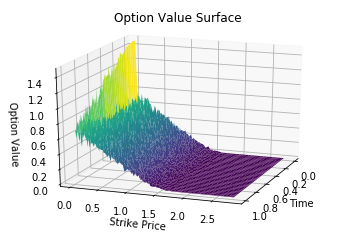

In [8]:
from mpl_toolkits import mplot3d
from scipy import ndimage

# 在一个二维网格上计算插值值
Z = f(x_T, y_K)

# 创建一个3D轴对象
fig = plt.figure()
ax = plt.axes(projection='3d')

# 绘制曲面
X, Y = np.meshgrid(x_T, y_K)
ax.plot_surface(X, Y, Z, cmap='viridis')

# 添加标签和标题
ax.set_xlabel('Time')
ax.set_ylabel('Strike Price')
ax.set_zlabel('Option Value')
ax.set_title('Option Value Surface')
ax.view_init(elev=20, azim=20)  # 将视角沿着 x 轴旋转 30 度
# 显示图形
img = plt.show()

In [9]:
# 下面开始进行期权定价
# Set up the Monte Carlo simulation
dt = time_to_maturity/1000 # time step
n_steps = int(time_to_maturity / dt)  #  1000
paths_local_final = np.zeros((10000, n_steps+1))
paths_local_final[:, 0] = S0  # the first column is the stock price of time 0
payoff_local_final = np.zeros((10000, n_steps+1))
delta = 10**(-8)
for k in range(10):
    vol_list = []
    for i in range(1, n_steps+1):   # 遍历1-1000
        t = dt*i    # 0.001,0.002...
        dW = np.random.normal(0, np.sqrt(dt), 10000)
        S = paths_local_final[:, i-1]  # 前一时刻的股价
        # 用Dupire方程求解局部波动率,f = interp2d(x_T, y_K, f_K_T, kind='cubic')
        dC_dK = f(t,K,dx=1) # 对K求偏导
        dC_dT = f(t,K,dy=1) # 对T求偏导
        d2C_dK2 = f(t,K,dx=1,dy=1) # 二阶偏导
        vol2 = max(0,(dC_dT+interest_rate*K*dC_dK)*2/(K*K*d2C_dK2))
        vol = np.sqrt(vol2)
        paths_local_final[:, i] = S * np.exp((interest_rate - 0.5 * vol**2) * dt + vol * dW)  # 当前股价
    # 以上生成了股价矩阵
    # 下面考虑股价存活情况
    for i in range(10000): # 模拟次数
        for j in range(1,1001): # 时间点1-1000
            # t_temp = j/1000*
            if (paths_local_final[i,j] < U and t_temp) or (j>=501 and j<=int(8/12*1000)+1) or (paths_local_final[i,j] > L and (j>=(int(8/12*1000)+1) and j<=(int(11/12*1000)+1))) or (paths_local_final[i,j]>=1.3 and paths_local_final[i,j]<=1.8 and j>=int(11/12*1000)+1):
                payoff_local_final[i,j] = np.maximum(0,paths_local_final[i,j]-K)
                if j == 1000:
                    mark = i
                    break
            else:
                paths_local_final[i,j:] = 0
                payoff_local_final[i,j] = 0
                mark0 = i
                break
    print("第{}次运行".format(k))
    print("Payoff_Mean:{}".format(payoff_local_final[:,-1].mean()))
    opt_v = payoff_local_final[:,-1]*np.exp(-interest_rate)
    print("option_value:{}".format(payoff_local_final[:,-1].mean()*np.exp(-1*interest_rate*1)))
    print("SE:{}".format(opt_v.std()/np.sqrt(10000)))

第0次运行
Payoff_Mean:0.06890248069963006
option_value:0.06686610464536828
SE:0.0009778773191636376
第1次运行
Payoff_Mean:0.08972802680077942
option_value:0.08707616284293722
SE:0.0010410129730335166
第2次运行
Payoff_Mean:0.09550080764186555
option_value:0.09267833222632366
SE:0.0010466160371334168
第3次运行
Payoff_Mean:0.09700563716207265
option_value:0.09413868731296059
SE:0.0010579690704379577
第4次运行
Payoff_Mean:0.09596558189419789
option_value:0.09312937032360792
SE:0.0010547183731545342
第5次运行
Payoff_Mean:0.09571233449990188
option_value:0.09288360752093057
SE:0.0010475466117675213
第6次运行
Payoff_Mean:0.09576385019537824
option_value:0.09293360069751325
SE:0.0010485415660686766
第7次运行
Payoff_Mean:0.09646283584624708
option_value:0.0936119282004134
SE:0.0010528517036243474
第8次运行
Payoff_Mean:0.0965914728954413
option_value:0.0937367634502528
SE:0.0010505995968249605
第9次运行
Payoff_Mean:0.09700613443146888
option_value:0.09413916988582513
SE:0.0010586268307323067


In [17]:
len(vol_list)

1000

In [60]:
payoff_local_final

array([[0.        , 0.09521959, 0.09494233, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.10969981, 0.10124056, ..., 0.30093681, 0.30939609,
        0.30812952],
       [0.        , 0.10039481, 0.09483514, ..., 0.15166173, 0.16086013,
        0.15263598],
       ...,
       [0.        , 0.09043077, 0.09767671, ..., 0.21154376, 0.20844316,
        0.1951384 ],
       [0.        , 0.10490594, 0.09859715, ..., 0.0750994 , 0.07308027,
        0.08062673],
       [0.        , 0.10364266, 0.10364963, ..., 0.00286657, 0.00737891,
        0.00670089]])

In [61]:
paths_local_final

array([[1.5       , 1.49521959, 1.49494233, ..., 1.33142293, 1.32681657,
        1.32916724],
       [1.5       , 1.50969981, 1.50124056, ..., 1.70093681, 1.70939609,
        1.70812952],
       [1.5       , 1.50039481, 1.49483514, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [1.5       , 1.49043077, 1.49767671, ..., 0.        , 0.        ,
        0.        ],
       [1.5       , 1.50490594, 1.49859715, ..., 0.        , 0.        ,
        0.        ],
       [1.5       , 1.50364266, 1.50364963, ..., 0.        , 0.        ,
        0.        ]])

In [10]:
mark

9998

In [11]:
mark0

9999

In [29]:
paths_local_final

array([[1.5, 0. , 0. , ..., 0. , 0. , 0. ],
       [1.5, 0. , 0. , ..., 0. , 0. , 0. ],
       [1.5, 0. , 0. , ..., 0. , 0. , 0. ],
       ...,
       [1.5, 0. , 0. , ..., 0. , 0. , 0. ],
       [1.5, 0. , 0. , ..., 0. , 0. , 0. ],
       [1.5, 0. , 0. , ..., 0. , 0. , 0. ]])

In [64]:
paths_local_final[mark]

array([1.5       , 1.5030875 , 1.50387797, ..., 1.50414687, 1.49939103,
       1.49178635])

In [65]:
paths_local_final[mark0]

array([1.5       , 1.50364266, 1.50364963, ..., 0.        , 0.        ,
       0.        ])

In [67]:
paths_local_final.shape

(10000, 1001)

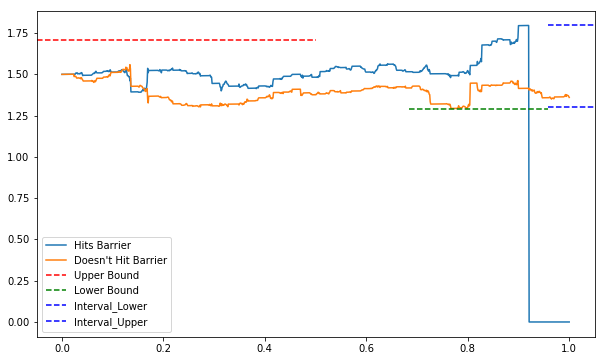

In [12]:
# Plot the sample paths
plt.figure(figsize=(10, 6))
t_grid = np.linspace(0, 1, 1001)
plt.plot(t_grid, paths_local_final[mark0], label='Hits Barrier')
plt.plot(t_grid, paths_local_final[mark], label = "Doesn't Hit Barrier")
# Add annotations for the upper and lower bounds
plt.axhline(y=1.71, linestyle='--', color='red', label='Upper Bound',xmin = 0,xmax = 0.5)
plt.axhline(y=1.29, linestyle='--', color='green', label='Lower Bound',xmin = 8/12, xmax = 11/12)
plt.axhline(y=1.3, linestyle='--', color='blue', label='Interval_Lower',xmin = 11/12, xmax = 1)
plt.axhline(y=1.8, linestyle='--', color='blue', label='Interval_Upper',xmin = 11/12, xmax = 1)
# Add legend
plt.legend()
# Show plot
plt.show()